In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pickle

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.4.1


In [3]:
train_dir = 'data/aclImdb/train/'

In [5]:
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

In [6]:
batch_size = 32
seed = 2021

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [60]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [61]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [62]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'data/aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### prepare the dataset for training

In [63]:
def custom_standardization(input_data):
      lowercase = tf.strings.lower(input_data)
      stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
      return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [64]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [65]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [66]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [67]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"Surprisingly enough does movie does have some redeeming quality in it when it moves toward its end. For the other part this movie is being a really bad and lame one, with a small budget, insultingly bad written script and everything that goes with it.<br /><br />It's silly that with all the money going around in the Christian circles they never can seem to get sufficient funds to make a decent movie with. I'm not a religious, so I couldn't care less really but film-making does some like a good tool to reach a new audience for churches and getting people more interested and curious in reading the bible for instance. In that regard these movies always seem like a wasted opportunity.<br /><br />The low budget does really hurt the movie and brings it down. It makes the movie laughable to watch with its effects and it just gives the overall movie a campy B-movie like feeling.<br /><br />But what's hurting this movie more is its writing. The stuff that just happens in this

In [71]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 77 ---> ",vectorize_layer.get_vocabulary()[77])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  plan
 77 --->  into
Vocabulary size: 10000


In [72]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [73]:
# configure the dataset for perdormance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [74]:
# create the model
embedding_dim = 16
drop_rate = 0.2
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(drop_rate),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(drop_rate),
    layers.Dense(1)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), 
             optimizer='adam',
             metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.0))

In [76]:
epochs = 30
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6625 - binary_accuracy: 0.6974 - val_loss: 0.6124 - val_binary_accuracy: 0.7664
Epoch 2/30
625/625 - 1s - loss: 0.5457 - binary_accuracy: 0.8036 - val_loss: 0.4969 - val_binary_accuracy: 0.8208
Epoch 3/30
625/625 - 1s - loss: 0.4419 - binary_accuracy: 0.8469 - val_loss: 0.4212 - val_binary_accuracy: 0.8464
Epoch 4/30
625/625 - 1s - loss: 0.3752 - binary_accuracy: 0.8676 - val_loss: 0.3771 - val_binary_accuracy: 0.8582
Epoch 5/30
625/625 - 1s - loss: 0.3322 - binary_accuracy: 0.8820 - val_loss: 0.3500 - val_binary_accuracy: 0.8616
Epoch 6/30
625/625 - 1s - loss: 0.3013 - binary_accuracy: 0.8900 - val_loss: 0.3321 - val_binary_accuracy: 0.8652
Epoch 7/30
625/625 - 1s - loss: 0.2793 - binary_accuracy: 0.9003 - val_loss: 0.3197 - val_binary_accuracy: 0.8680
Epoch 8/30
625/625 - 1s - loss: 0.2598 - binary_accuracy: 0.9056 - val_loss: 0.3108 - val_binary_accuracy: 0.8706
Epoch 9/30
625/625 - 1s - loss: 0.2432 - binary_accuracy: 0.9118 - val_loss: 0.3044 - va

In [77]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.3331 - binary_accuracy: 0.8678
Loss:  0.33314836025238037
Accuracy:  0.8677999973297119


In [78]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

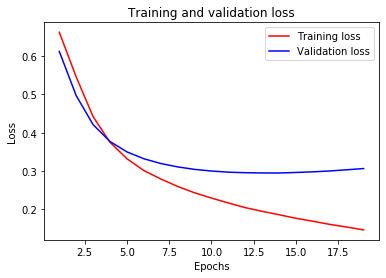

In [79]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

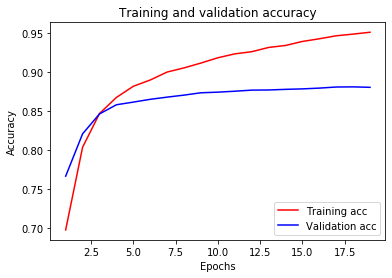

In [80]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### saving the model

In [ ]:
def export_vertorized_model(vetor_layer, model, eval_ds, export=False):

    # Pickle the config and weights
    pickle.dump({'config': vetor_layer.get_config(),
                 'weights': vetor_layer.get_weights()}
                , open("model/vectorized_model.pkl", "wb"))

    loss, accuracy = model.evaluate(eval_ds)
    print(accuracy)
    if export == True:
        model.save('model/vectorized_model')

### load and re-use the model

In [40]:
new_model = tf.keras.models.load_model('model/vectorized_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [51]:
with open('model/vectorized_model.pkl', 'rb') as r:
    config_file = pickle.load(r)
    vt_layer = TextVectorization.from_config(config_file['config'])
    # You have to call `adapt` with some dummy data (BUG in Keras)
    vt_layer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
    vt_layer.set_weights(config_file['weights'])

In [48]:
# load test data
text_pth = 'data/aclImdb/'
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(text_pth, 'test/'),
    batch_size=64)

Found 25000 files belonging to 2 classes.


In [53]:
export_model = tf.keras.Sequential([
  vt_layer,
  new_model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [54]:
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

391/391 [==============================] - 3s 6ms/step - loss: 0.3171 - accuracy: 0.8713
0.8720800280570984
